In [1]:
cd ~/work/repos/modl/examples/contrast/

/storage/store/work/amensch/work/repos/modl/examples/contrast


In [2]:
ls

analysis/                    predict_contrast_new.py  prepare.py
Multiclass tensorflow.ipynb  predict_contrast.py      __pycache__/
multi_predict_contrast.py    prediction.csv           reduce_contrast.py


In [1]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [14]:
%matplotlib inline

def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(20, 20))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [5]:
cd ~/data/modl_data/pipeline/contrast/prediction_hierarchical/None/

/home/arthur/data/modl_data/pipeline/contrast/prediction_hierarchical/None


In [78]:
prediction = pd.read_csv('prediction_depth_2.csv')

In [79]:
prediction = prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast',])

In [80]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [81]:
labels = prediction['true_label'].unique()

In [82]:
from sklearn.metrics import confusion_matrix

In [83]:
prediction.loc['train', 'predicted_label']

dataset     subject  task       contrast                   
archi       1        emotional  expression_control                          archi__emotional__expression_control
                                expression_intention                      archi__emotional__expression_intention
                                expression_sex                                  archi__emotional__expression_sex
                                face_control                                      archi__emotional__face_control
                                face_sex                                              archi__emotional__face_sex
                                face_trusty                                        archi__emotional__face_trusty
                     localizer  audio                                                    archi__localizer__audio
                                calculaudio                                        archi__localizer__calculaudio
                                calc

In [84]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

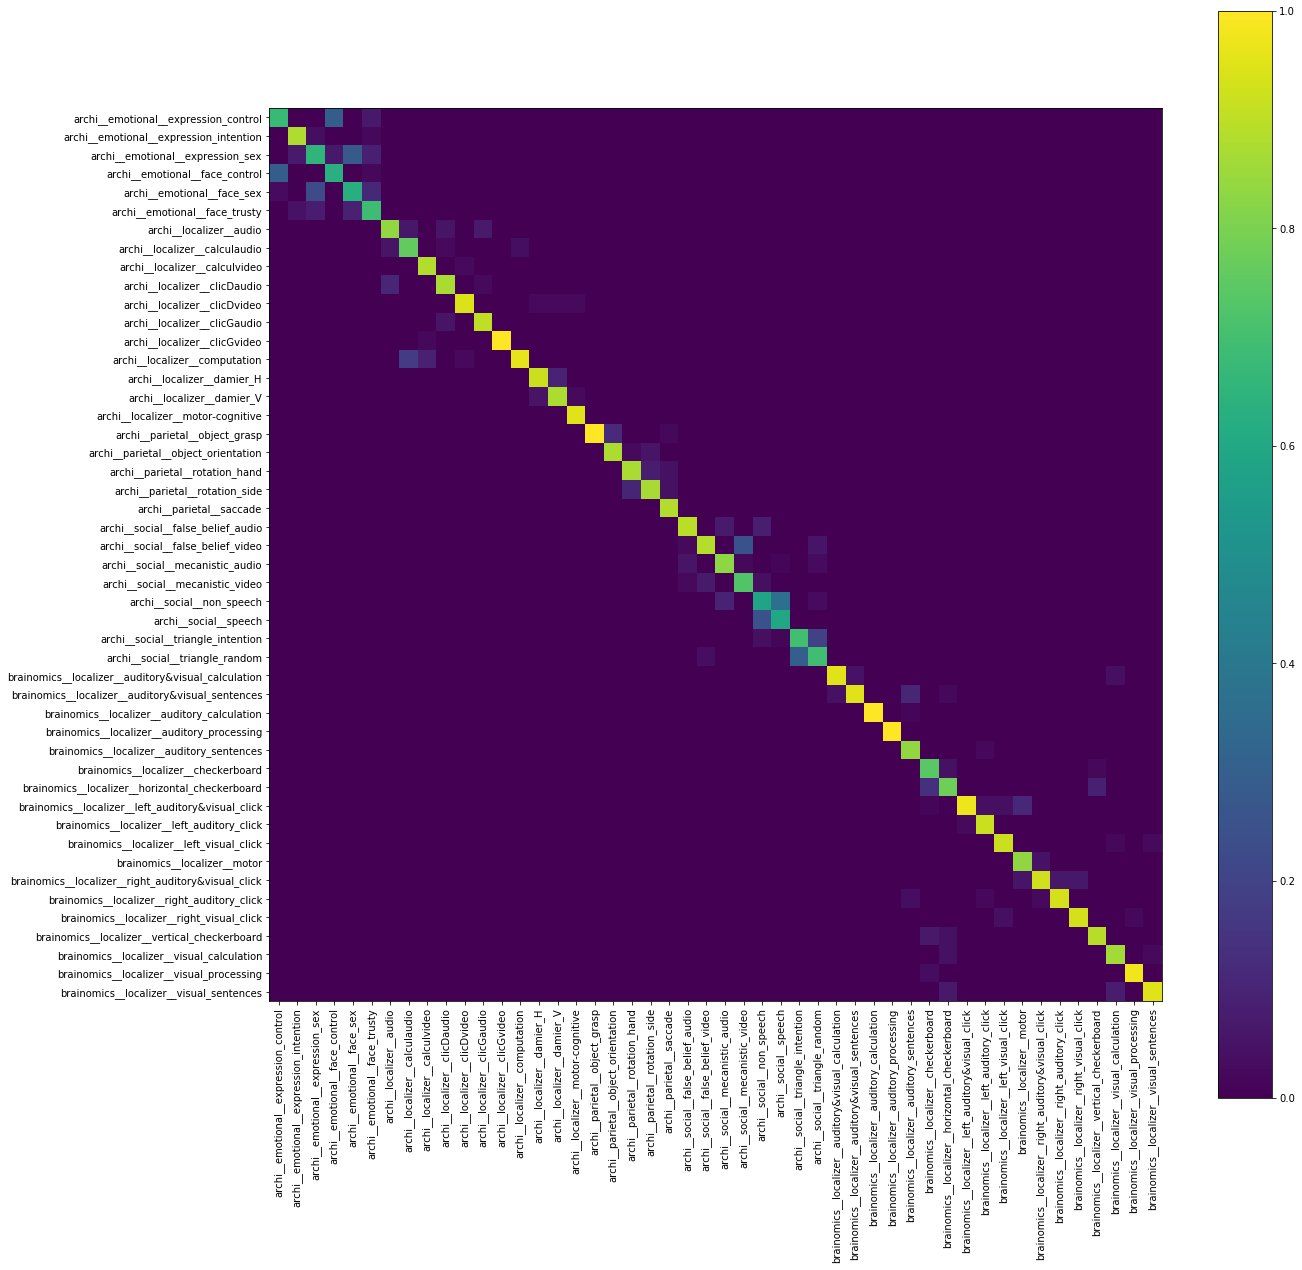

In [86]:
plot_confusion_matrix(test_conf[:50, :50], labels[:50])

In [41]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task        contrast            
archi    emotional   expression_control      0.692308
                     expression_intention    0.923077
                     expression_sex          0.615385
                     face_control            0.487179
                     face_sex                0.743590
                     face_trusty             0.794872
         localizer   audio                   0.897436
                     calculaudio             0.923077
                     calculvideo             0.871795
                     clicDaudio              0.948718
                     clicDvideo              0.948718
                     clicGaudio              1.000000
                     clicGvideo              0.948718
                     computation             0.846154
                     damier_H                0.948718
                     damier_V                0.974359
                     motor-cognitive         1.000000
         parietal    object_grasp       

In [ ]:
idx = pd.IndexSlice
prediction.loc[idx['test']]

In [43]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.852991
       hcp        0.891029
       la5c       0.557812
train  archi      0.993162
       hcp        0.916508
       la5c       0.748754
Name: match, dtype: float64

In [ ]:
classifier = estimator.named_steps['classifier']

In [ ]:
histories = classifier.histories_

In [ ]:
history.epoch

In [ ]:
for history, n_samples in zip(histories, classifier.n_samples_):
    plt.plot(np.array(history.epoch) * n_samples, history.history['val_acc'])

In [ ]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [ ]:
np.mean(w0 == 0),np.mean(w1 == 0)

In [ ]:
np.histogram(w1)

In [ ]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)